# Running the Deutsch–Jozsa algorithm on the noisy device simulator

Author: Boxi Li (etamin1201@gmail.com)

In this example, we demonstrate how to simulate simple quantum algorithms on a qauntum hardware with QuTiP. The simulators are defined in the class `Processor`(and its sub-classes). `Processor` represents a general quantum device. The interaction of the quantum systems such as qubits is defined by the control Hamiltonian. One can set the amplitude of the interaction by the attribute `coeff` which corresponds to the pulse intensity of the control system. For more details please refer to [the introductory notebook](qip-noisy-device-simulator.ipynb).

In this example, we won't set the interaction strength by ourselves. Instead, we give it a sequence of gates, i.e. a `QubitCircuit`, and let the `Processor` find the desired pulses. The `Processor` class has a method `load_circuit` that can transfer a `QubitCircuit` object into a control pulse sequence. Different sub-class of `Processor` find their pulses in different ways. We show two examples here, one is based on a physical model and the other uses the `qutip.control` module. For each case, we also compare the result with or without noise by defining the `t1` and `t2` time of the device.

## The Deutsch–Jozsa algorithm
The Deutsch–Jozsa algorithm is the simplest quantum algorithm that offers an exponential speed-up compared to the classical one. It assumes that we have a function $f:\{0,1\}^n \rightarrow \{0,1\}$ which is either balanced or constant. Constant means that $f(x)$ is either 1 or 0 for all inputs while balanced means that $f(x)$ is 1 for half of the input domain and 0 for the other half. A more rigorous definition can be found at https://en.wikipedia.org/wiki/Deutsch-Jozsa_algorithm.

The implementation of the Deutsch–Jozsa algorithm inclues $n$ input qubits and 1 ancilla initialised in state $1$. At the end of the algorithm, the first $n$ qubits are measured on the computational basis. If the function is constant, the result will be $0$ for all $n$ qubits. If balanced, $\left|00...0\right\rangle$ will never be measured.
The following example is implemented for the balanced function $f:\{00,01,10,11\} \rightarrow \{0,1\}$, where $f(00)=f(11)=0$ and $f(01)=f(10)=1$. This function is balanced, so the probability of measuring state $\left|00\right\rangle$ should be 0.

In [1]:
import numpy as np
from qutip_qip.device import OptPulseProcessor, LinearSpinChain
from qutip_qip.circuit import QubitCircuit
from qutip import sigmaz, sigmax, identity, tensor, basis, ptrace
basis00 = tensor([basis(2,0), basis(2,0)])

In [2]:
qc = QubitCircuit(N=3)
qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)
qc.add_gate("SNOT", targets=2)

# function f(x)
qc.add_gate("CNOT", controls=0, targets=2)
qc.add_gate("CNOT", controls=1, targets=2)

qc.add_gate("SNOT", targets=0)
qc.add_gate("SNOT", targets=1)

## Using the optimal control module to find the pulse
This feature integrated into the sub-class `OptPulseProcessor` which use methods in the optimal control module to find the optimal pulse sequence for the desired gates. It can find the optimal pulse either for the whole unitary evolution or for each gate. Here we choose the second option.

In [3]:
setting_args = {"SNOT": {"num_tslots": 5, "evo_time": 1},
                "CNOT": {"num_tslots": 12, "evo_time": 5}}
processor = OptPulseProcessor(N=3)
processor.add_control(sigmaz(), cyclic_permutation=True)
processor.add_control(sigmax(), cyclic_permutation=True)
processor.add_control(tensor([sigmax(), sigmax(), identity(2)]))
processor.add_control(tensor([identity(2), sigmax(), sigmax()]))
processor.load_circuit(qc, setting_args=setting_args, merge_gates=False, verbose=True,
                  amp_ubound=5, amp_lbound=0);

********** Gate 0 **********
Final fidelity error 3.6451530682768407e-10
Final gradient normal 9.53725296486059e-06
Terminated due to function converged
Number of iterations 18
********** Gate 1 **********
Final fidelity error 1.0518405035853107e-09
Final gradient normal 1.920199999957469e-05
Terminated due to function converged
Number of iterations 17
********** Gate 2 **********
Final fidelity error 1.9734214262712158e-12
Final gradient normal 5.2600567793809055e-06
Terminated due to Goal achieved
Number of iterations 14
********** Gate 3 **********
Final fidelity error 5.292202648998767e-06
Final gradient normal 0.0008412511079035319
Terminated due to function converged
Number of iterations 51
********** Gate 4 **********
Final fidelity error 1.3436790680110278e-08
Final gradient normal 3.199467495118891e-05
Terminated due to function converged
Number of iterations 77
********** Gate 5 **********
Final fidelity error 9.313494420126744e-11
Final gradient normal 1.9911063312810797e-05

To quickly visualize the pulse, `Processor` has a method called `plot_pulses`. In the figure bellow, each colour represents the pulse sequence of one control Hamiltonian in the system as a function of time. In each time interval, the pulse remains constant.

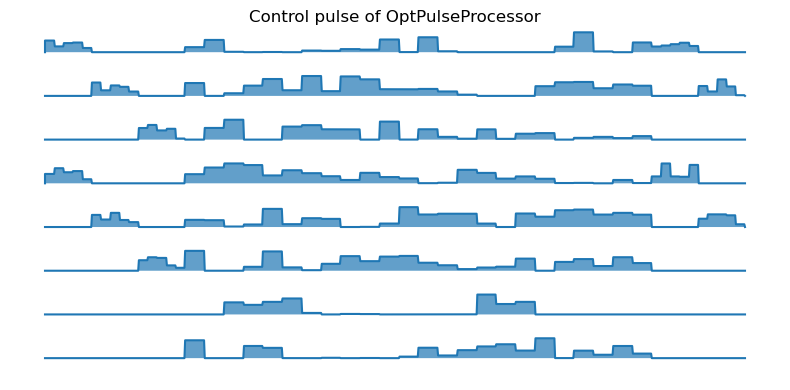

In [4]:
processor.plot_pulses(title="Control pulse of OptPulseProcessor", figsize=(8, 4), dpi=100);

To simulate the evolution, we only need to call the method `run_state` which calls one of the open system solvers in QuTiP and calculate the time evolution.
### Without decoherence

In [5]:
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
3.0836764469919137e-07


### With decoherence

In [6]:
processor.t1 = 100
processor.t2 = 30
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = processor.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.08445690437996706


We can see that under noisy evolution their is a none zero probability of measuring state 00.

## Generating pulse based on quantum computing model
Below, we simulate the same quantum circuit using one sub-class `LinearSpinChain`. It will find the pulse based on the Hamiltonian available on a quantum computer of the linear spin chain system.
Please refer to [the notebook of the spin chain model](https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/spin-chain-model.ipynb) for more details.

In [7]:
processor2 = LinearSpinChain(3)
processor2.load_circuit(qc);

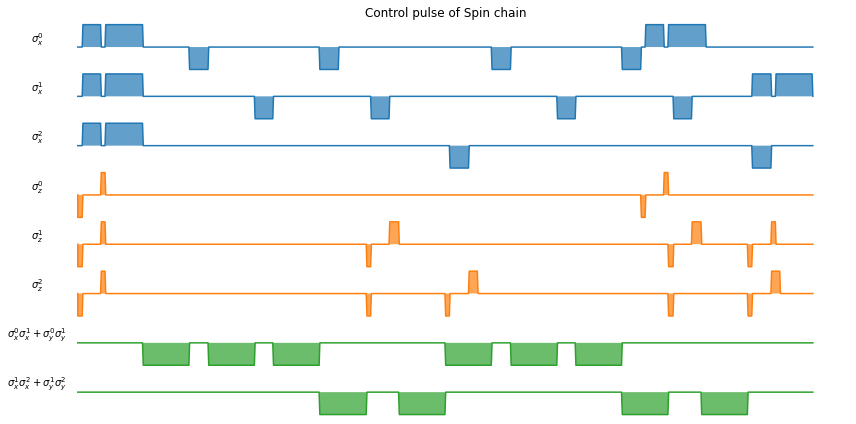

In [8]:
processor2.plot_pulses(title="Control pulse of Spin chain");

The first three pulse periods (from $t=0$ to $t\approx5$) are for the three Hadamard gates, they are followed by two long periods for the CNOT gates and then again two Hadamard. Different colours represent different kinds of interaction, as shown in the legend.

### Without decoherence

In [9]:
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = processor2.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
5.118049843492199e-08


### With decoherence

In [10]:
processor2.t1 = 100
processor2.t2 = 30
psi0 = tensor([basis(2, 0), basis(2, 0), basis(2, 1)])
result = processor2.run_state(init_state=psi0)
print("Probability of measuring state 00:")
print(np.real((basis00.dag() * ptrace(result.states[-1], [0,1]) * basis00)[0,0]))

Probability of measuring state 00:
0.13931341308865142


In [11]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.6.0+c003ff5
Numpy,1.20.1
SciPy,1.5.3
matplotlib,3.3.0
Cython,0.29.21
Number of CPUs,12
BLAS Info,Generic
IPython,7.16.1
Python,"3.8.6 | packaged by conda-forge | (default, Oct 7 2020, 18:22:52) [MSC v.1916 64 bit (AMD64)]"
OS,nt [win32]
